In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)

In [38]:
PATHS = {
    'lm_dict': '../sentiment-analysis/Loughran-McDonald_MasterDictionary_1993-2024.csv',
    'estonia': '../../data/regular-reports/estonia-reports.csv',
    'latvia': '../../data/regular-reports/latvia-reports.csv',
    'lithuania': '../../data/regular-reports/lithuania-reports.csv',
    'bulgaria': '../../data/regular-reports/bulgaria-reports.csv',
    'turkey': '../../data/regular-reports/turkey-reports.csv',
    'chapters_meta': '../../data/metadata/chapters_metadata.csv'
}

In [39]:
# Loughran-McDonald dictionary
lm_dict = pd.read_csv(PATHS['lm_dict'])
negative_words = set(lm_dict[lm_dict['Negative'] != 0]['Word'].str.lower())
positive_words = set(lm_dict[lm_dict['Positive'] != 0]['Word'].str.lower())

print(f" {len(positive_words)} positive, {len(negative_words)} negative words")

 354 positive, 2355 negative words


In [40]:
def clean_text(text):
    if pd.isna(text):
        return []
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', ' ', text)  # only letters and spaces
    return text.split()

def calculate_sentiment(text):
    """
    Calculate sentiment scores using Loughran-McDonald dictionary
    
    Returns:
        dict: Contains word counts, ratios, and net sentiment
    """
    words = clean_text(text)
    total_words = len(words)
    
    if total_words == 0:
        return {
            'total_words': 0,
            'negative_count': 0,
            'positive_count': 0,
            'negative_ratio': 0,
            'positive_ratio': 0,
            'net_sentiment': 0
        }
    
    # count sentiment words
    negative_count = sum(1 for w in words if w in negative_words)
    positive_count = sum(1 for w in words if w in positive_words)

    negative_ratio = (negative_count / total_words) * 1000
    positive_ratio = (positive_count / total_words) * 1000
    net_sentiment = positive_ratio - negative_ratio
    
    return {
        'total_words': total_words,
        'negative_count': negative_count,
        'positive_count': positive_count,
        'negative_ratio': negative_ratio,
        'positive_ratio': positive_ratio,
        'net_sentiment': net_sentiment
    }

In [41]:
def process_country_data(filepath, country_name):
    """Process Regular Reports for a single country"""
    print(f"  Processing {country_name}...")
    df = pd.read_csv(filepath)
    
    results = []
    for idx, row in df.iterrows():
        year = row['Year']
        
        # Process each column (section)
        for col in df.columns:
            if col in ['Country', 'Pages', 'Year']:
                continue
            
            text = row[col]
            sentiment = calculate_sentiment(text)
            
            # Only include sections with text
            if sentiment['total_words'] > 0:
                result = {
                    'country': country_name,
                    'year': year,
                    'section': col,
                    **sentiment
                }
                results.append(result)
    
    return pd.DataFrame(results)

In [43]:
countries_data = [
    (PATHS['estonia'], 'Estonia', 2004),
    (PATHS['latvia'], 'Latvia', 2004),
    (PATHS['lithuania'], 'Lithuania', 2004),
    (PATHS['bulgaria'], 'Bulgaria', 2007),
    (PATHS['turkey'], 'Turkey', 0)
]

all_results = []
for filepath, country_name, accession_year in countries_data:
    country_results = process_country_data(filepath, country_name)
    country_results['accession_year'] = accession_year
    all_results.append(country_results)
    
df_all = pd.concat(all_results, ignore_index=True)

print(f"\n  Total observations: {len(df_all)}")
print(f"  Countries: {', '.join(df_all['country'].unique())}")

  Processing Estonia...
  Processing Latvia...
  Processing Lithuania...
  Processing Bulgaria...
  Processing Turkey...

  Total observations: 2126
  Countries: Estonia, Latvia, Lithuania, Bulgaria, Turkey


In [44]:
df_all = df_all[df_all['section'].str.startswith("Chapter")]
df_all

,country,year,section,total_words,negative_count,positive_count,negative_ratio,positive_ratio,net_sentiment,accession_year
21,Estonia,1998,Chapter 1: Free movement of Goods,350,7,6,20.000000,17.142857,-2.857143,2004
22,Estonia,1998,Chapter 2: Free movement of Persons,146,0,0,0.000000,0.000000,0.000000,2004
23,Estonia,1998,Chapter 3: Freedom to provide services,192,5,0,26.041667,0.000000,-26.041667,2004
24,Estonia,1998,Chapter 4: Free movement of capital,92,0,1,0.000000,10.869565,10.869565,2004
25,Estonia,1998,Chapter 6: Competition policy,114,1,0,8.771930,0.000000,-8.771930,2004
...,...,...,...,...,...,...,...,...,...,...
2121,Turkey,2016,Chapter 25: Customs union,420,4,7,9.523810,16.666667,7.142857,0
2122,Turkey,2016,Chapter 26: External relations,466,7,4,15.021459,8.583691,-6.437768,0
2123,Turkey,2016,Chapter 27: Common Foreign and Security Policy,1072,23,8,21.455224,7.462687,-13.992537,0
2124,Turkey,2016,Chapter 28: Financial Control,1450,27,18,18.620690,12.413793,-6.206897,0


In [47]:
df_all['chapter_number'] = df_all['section'].str.extract(r'Chapter\s+(\d+):')
df_all['chapter_number'] = pd.to_numeric(df_all['chapter_number'], errors='coerce')

df_chapters = df_all[df_all['chapter_number'].notna()].copy()

print(f"  Chapter-level observations: {len(df_chapters)}")
print(f"  Observations by country:")
for country in sorted(df_chapters['country'].unique()):
    n = len(df_chapters[df_chapters['country'] == country])
    print(f"    {country}: {n}")

  Chapter-level observations: 1136
  Observations by country:
    Bulgaria: 199
    Estonia: 141
    Latvia: 141
    Lithuania: 141
    Turkey: 514


In [48]:
df_chapters

,country,year,section,total_words,negative_count,positive_count,negative_ratio,positive_ratio,net_sentiment,accession_year,chapter_number
21,Estonia,1998,Chapter 1: Free movement of Goods,350,7,6,20.000000,17.142857,-2.857143,2004,1.0
22,Estonia,1998,Chapter 2: Free movement of Persons,146,0,0,0.000000,0.000000,0.000000,2004,2.0
23,Estonia,1998,Chapter 3: Freedom to provide services,192,5,0,26.041667,0.000000,-26.041667,2004,3.0
24,Estonia,1998,Chapter 4: Free movement of capital,92,0,1,0.000000,10.869565,10.869565,2004,4.0
25,Estonia,1998,Chapter 6: Competition policy,114,1,0,8.771930,0.000000,-8.771930,2004,6.0
...,...,...,...,...,...,...,...,...,...,...,...
2121,Turkey,2016,Chapter 25: Customs union,420,4,7,9.523810,16.666667,7.142857,0,25.0
2122,Turkey,2016,Chapter 26: External relations,466,7,4,15.021459,8.583691,-6.437768,0,26.0
2123,Turkey,2016,Chapter 27: Common Foreign and Security Policy,1072,23,8,21.455224,7.462687,-13.992537,0,27.0
2124,Turkey,2016,Chapter 28: Financial Control,1450,27,18,18.620690,12.413793,-6.206897,0,28.0


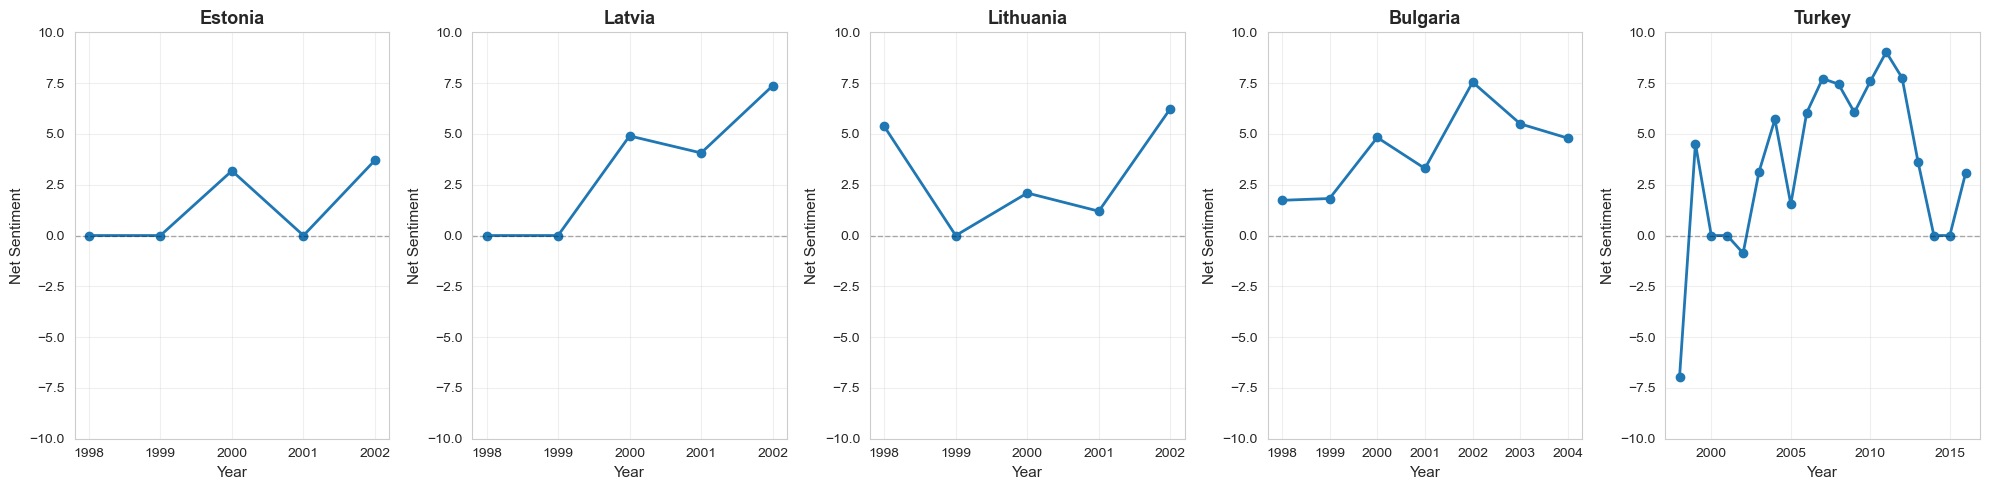


Countries in dataframe: ['Estonia', 'Latvia', 'Lithuania', 'Bulgaria', 'Turkey']

Year range by country:
Estonia: 1998 - 2002
Latvia: 1998 - 2002
Lithuania: 1998 - 2002
Bulgaria: 1998 - 2004
Turkey: 1998 - 2016


In [58]:
import matplotlib.pyplot as plt
import pandas as pd

countries = df_chapters['country'].unique()
n_countries = len(countries)

fig, axes = plt.subplots(1, n_countries, figsize=(4*n_countries, 5))

for idx, country in enumerate(countries):
    ax = axes[idx]
    
    country_data = df_chapters[df_chapters['country'] == country].groupby('year')['net_sentiment'].median().reset_index()
    
    # plot
    ax.plot(country_data['year'], country_data['net_sentiment'], marker='o', linewidth=2, markersize=6)

    ax.set_ylim(-10, 10)
    ax.set_xlabel('Year', fontsize=11)
    ax.set_ylabel('Net Sentiment', fontsize=11)
    ax.set_title(f'{country}', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.3, linewidth=1)

plt.tight_layout()
plt.show()

print(f"\nCountries in dataframe: {list(countries)}")
print(f"\nYear range by country:")
for country in countries:
    country_data = df_chapters[df_chapters['country'] == country]
    print(f"{country}: {country_data['year'].min()} - {country_data['year'].max()}")